# TP 7 – Monte Carlo générique et options de chemin

Ce TP illustre le module `pricing.montecarlo` et le lien avec `process`.

Objectifs :
- comprendre l’abstraction `StochasticProcess` et `Diffusion1D`;
- utiliser `MonteCarloEngine` pour simuler des trajectoires;
- construire un pricer d’option asiatique à partir de trajectoires (option de chemin).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fypy.pricing.montecarlo.DiffusionStochasticProcess import DiffusionStochasticProcess, BlackScholesDiffusion1D
from fypy.pricing.montecarlo.MonteCarloEngine import MonteCarloEngine, Trajectory, AdditionalState, RealizedVol
from fypy.pricing.montecarlo.TrajectoryPricer import TrajectoryPricer

%matplotlib inline

## 1. Processus de diffusion 1D et StochasticProcess

Une diffusion 1D est décrite par :
\[
dS_t = \mu(S_t, t) \, dt + \sigma(S_t, t) \, dW_t.
\]

Dans fypy :
- `Diffusion1D` définit l’interface via `mu_dt` et `sigma_dt` (increments sur un pas `dt`);
- `BlackScholesDiffusion1D` implémente le cas classique \( \mu = r - q, \sigma = \text{constante} \);
- `DiffusionStochasticProcess` emballe une diffusion 1D dans un `StochasticProcess` utilisable par `MonteCarloEngine`.

In [2]:
# Paramètres de base
S0 = 100.0
r = 0.03
q = 0.0
sigma = 0.2

# Diffusion Black-Scholes
bs_diffusion = BlackScholesDiffusion1D(r=r, sigma=sigma, q=q)
process = DiffusionStochasticProcess(S0=S0, diffusion=bs_diffusion)

# Moteur Monte Carlo
engine = MonteCarloEngine(stochastic_process=process,
                          n_paths=5000,
                          dt=1.0 / 252.0)  # pas journalier approx.

## 2. Simulation de trajectoires et visualisation

Nous simulons quelques trajectoires sur \([0,T]\) et les visualisons pour vérifier le comportement lognormal.


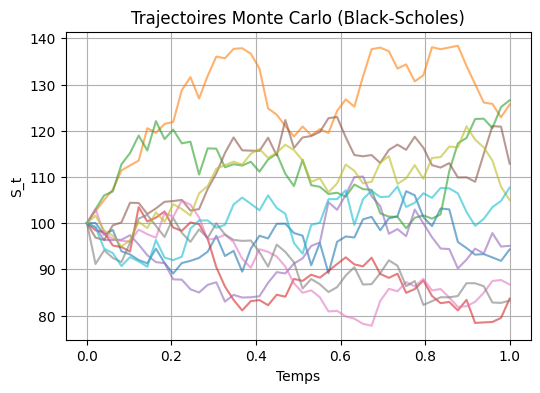

In [3]:
T = 1.0
observation_times = np.linspace(0.0, T, 50)

traj = engine.evolve(observation_times=observation_times)
times = traj.get_times()

# Affichons quelques trajectoires (composante unique de l'état)
plt.figure(figsize=(6, 4))
for i in range(10):
    path = traj.get_component_trajectory(i, state_index=0)
    plt.plot(times, path, alpha=0.6)

plt.xlabel('Temps')
plt.ylabel('S_t')
plt.title('Trajectoires Monte Carlo (Black-Scholes)')
plt.grid(True)
plt.show()

## 3. Option asiatique via Monte Carlo générique

Nous allons maintenant :
- définir un `TrajectoryPricer` qui transforme un `Trajectory` en prix d'option asiatique;
- utiliser `MonteCarloEngine` pour générer les trajectoires;
- comparer grossièrement avec l’approximation de Vorst du TP 5.


In [4]:
class AsianCallPricer(TrajectoryPricer):
    def __init__(self, K: float, T: float):
        self._K = K
        self._T = T

    def get_observation_times(self) -> np.array:
        # Pour une asiatique discrète, on définit simplement une grille uniforme de dates d’observation
        return np.linspace(0.0, self._T, 50)

    def price(self, trajectories: Trajectory) -> np.array:
        times = trajectories.get_times()
        idx_T = np.argmax(times)  # dernier indice (proche de T)
        # Etats : shape (n_paths, state_dim, n_times)
        n_paths = trajectories.get_num_trajectories()
        payoffs = np.zeros(n_paths)
        for i in range(n_paths):
            path = trajectories.get_component_trajectory(i, state_index=0)
            avg_S = np.mean(path[:idx_T + 1])
            payoffs[i] = max(avg_S - self._K, 0.0)
        return np.exp(-r * self._T) * payoffs


K_asian = 100.0
T = 1.0

asian_pricer = AsianCallPricer(K=K_asian, T=T)
obs_times = asian_pricer.get_observation_times()

traj = engine.evolve(observation_times=obs_times)
payoffs_actualises = asian_pricer.price(traj)
prix_mc = np.mean(payoffs_actualises)
err_mc = np.std(payoffs_actualises) / np.sqrt(engine._n_paths)

print('Prix MC asiatique (call)  :', prix_mc)
print('Erreur std MC approx.    :', err_mc)

Prix MC asiatique (call)  : 5.385610028279867
Erreur std MC approx.    : 0.10937742174137303


En augmentant le nombre de chemins `n_paths`, le prix Monte Carlo se stabilise. Vous pouvez comparer ce résultat
à l’approximation de Vorst (`asian_vorst_approx_price`) en reprenant les paramètres de ce TP.


## 4. États additionnels : volatilité réalisée, maximum, etc.

Le moteur Monte Carlo de fypy supporte des **états additionnels** via la classe `AdditionalState` :
- `RunningMaximum` suit le maximum atteint par \( S_t \) (utile pour lookbacks, barrière up-and-out, etc.);
- `RunningMinimum` suit le minimum (barrières down-and-out, etc.);
- `RealizedVol` suit une approximation de la volatilité réalisée.

Le principe :
- au début, `initialize` reçoit l'état initial du processus;
- à chaque pas de temps, `evolve` observe l’ancien et le nouvel état et met à jour la quantité d’intérêt;
- à la fin, `get_state` renvoie la variable (ex. volatilité réalisée) qui peut être utilisée pour le pricing.

Vous pouvez, par exemple, ajouter `RealizedVol` à `MonteCarloEngine` et construire une option de variance ou de
volatilité réalisée comme exercice.